## Topic modeling for positive sentiment posts

Having classified the posts based on their sentiment towards the Singapore government's handling of the COVID-19 outbreak in foreign worker dormitories, I will now do an analysis on the topics in the posts. 

**I will investigate the posts with negative and positive sentiment, which the audience (government agencies) would be more interested in.** 

Topic modeling will be done in this sequence: 
1. Extracting positive sentiment posts from labelled data
2. Processing data 
- Tokenize
- Remove stop words
- Lemmatize 
3. Visualise top words in posts 
4. Vanilla topic modeling with Latent Dirichlet Allocation model with hyperparameter tuning 
5. LDA modeling with the MALLET (MAchine Learning for LanguagE Toolkit) topic model package
- MALLET is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text.
- Based on research, this package seems to be able to improve accuracy of topics
6. Topics of positive sentiment posts based on best model 

Topics found with optimised LDA topic modeling with MALLET (best model):
- Topic 1: **cases, community, numbers, dormitory, news, forum, big, spread, cb, world**
    - highlighted high ("big") number of COVID-19 cases in dorms, potential for community spread and the circuit breaker ("cb")
- Topic 2: **conditions, pay, migrant, thing, issue, country, cost, distancing, operators, singaporeans**
    - highlighted poor conditions and pay of migrant workers, cost of distancing workers, responsibility of dorm operators ("operators")
- Topic 3: **government, sg, high, citizens, companies, care, hard, day, agree, lot**
    - pointed out that government cared for citizens and companies
- Topic 4: **people, masks, time, mask, lockdown, weeks, home, hindsight, long, wearing**
    - highlighted COVID-19 situation in Singapore - mask wearing, lockdown for weeks/long time, benefit of "hindsight" 
- Topic 5: **work, make, clusters, measures, start, point, days, making, made, life**
    - highlighted clusters, possibly mentioned measures to stop spread

---
## Importing libraries and labelled data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data 

all_posts = pd.read_csv('./labelled_posts/all_posts_labelled.csv')
all_posts.head()

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
1,">For consistency and accuracy, it could be eas...",0.0,2020-04-11 12:26:38,reddit,for consistency and accuracy it could be easie...,consistency accuracy could easier use data new...
2,Only IQ lower than 86 will believe this CSB.Wh...,0.0,2020-04-23 10:42:00,hardwarezone,only iq lower than 86 will believe this csb wh...,iq lower 86 believe csb maids pregnant nothing...
3,I work nearby to the Westlite and Toh Guan Dor...,0.0,2020-04-06 20:55:47,reddit,i work nearby to the westlite and toh guan dor...,work nearby westlite toh guan initial reports ...
4,Ho seh liao,0.0,2020-09-04 21:43:00,hardwarezone,ho seh liao,ho seh


In [3]:
#keep only negative sentiment posts 
pos = all_posts[all_posts['label'] == 2]
display(pos.shape)
pos.head()

(241, 6)

,post,label,date,source,post_clean_rnn,post_clean_nb_logreg
0,There is no new cluster beside the dorm for tw...,2.0,2020-10-04 08:34:00,hardwarezone,there is no new cluster beside the dorm for tw...,no new cluster beside two days
7,Exactly. People don’t even wanna let our publi...,2.0,2020-05-27 20:28:30,reddit,exactly people don t even wanna let our public...,exactly people even wanna let public servants ...
12,I feel that your views are quite myopic.\n\nHa...,2.0,2020-05-02 18:41:32,reddit,i feel that your view are quite myopic have yo...,feel views quite myopic seen housed transporte...
14,Wong said that it was a very unpredictable sit...,2.0,2020-09-04 21:37:00,sgtalk,wong said that it wa a very unpredictable situ...,wong said unpredictable situation w n press co...
17,DEPORT ALL FTRASH .FWs are our frens. They bui...,2.0,2020-07-04 01:02:00,hardwarezone,deport all ftrash fws are our frens they built...,deport ftrash fws frens built nation dun assoc...


In [4]:
#drop date (which is not accurate), post_clean_rnn, post_clean_nb_logreg

pos.drop(columns = ['date', 'post_clean_rnn', 'post_clean_nb_logreg'], inplace=True)
pos.head(2)

,post,label,source
0,There is no new cluster beside the dorm for tw...,2.0,hardwarezone
7,Exactly. People don’t even wanna let our publi...,2.0,reddit


---
## Preprocessing of posts

In [5]:
#dealing with stopwords 

# first cut - removing words from stopwords that indicate sentiment 
# remove_words = ["no", "not", "against", "don't", "should", "should've", "couldn", "couldn't",'didn', "didn't",
#                    'doesn',"doesn't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",
#                    'wouldn',"wouldn't"]

stopwords = stopwords.words('english')
print(len(stopwords))

# also adding words that are either common words, singaporean slang or noisy words from forum posts

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
#              '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
#             'xiaomi', 'l21a', '32']

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'dorm', 'dorms', 'dormitory', 'dormitories', 'covid', 
#              '19', 'cases', 'virus', 'coronavirus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
#             'xiaomi', 'l21a', '32', 'government', 'gov', 'govt']

# add_words = ['foreign', 'migrant', 'worker', 'workers', 'fw', 'covid', '19', 'cases', 'virus', 'coronavirus', 
#       'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung','xiaomi', 'l21a', '32', 'government', 'gov', 'govt']

add_words = ['19', 'virus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung',
            'xiaomi', 'l21a', '32']
stopwords.extend(add_words)
len(stopwords)

179


191

In [6]:
def preprocess(word):
     
    # tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
    no_stop = [word for word in tokens if word not in stopwords]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [7]:
post_clean = []

for p in pos["post"]:
    post_clean.append(preprocess(p))

print(f"checking post_clean: \n{post_clean[0:3]}")

pos['post_clean_lda'] = post_clean
pos.head()

checking post_clean: 
['new cluster beside dorm two days', 'exactly people even wanna let public servants rest', 'feel views quite myopic seen migrant workers housed transported treated like woodpile imagine safety hygiene standards dormitories trucks scores workers transported without seat belts harnesses obvious lives workers matter less average singaporean person western media looks middle east singapore entirely different lenses pretty obvious reasons precisely able avoid public eye sign developed economy one unskilled labourers welders fitters electricians earn good healthy income instance lolly pop man australia earn upto 120k aud factor 30 40 tax still take home 70 80k roles taken australians folks south asia china flip side educated class earning wages dissimilar either words income gap quite narrow regulated tell tale sign good healthy developed economy far cry see singapore']


,post,label,source,post_clean_lda
0,There is no new cluster beside the dorm for tw...,2.0,hardwarezone,new cluster beside dorm two days
7,Exactly. People don’t even wanna let our publi...,2.0,reddit,exactly people even wanna let public servants ...
12,I feel that your views are quite myopic.\n\nHa...,2.0,reddit,feel views quite myopic seen migrant workers h...
14,Wong said that it was a very unpredictable sit...,2.0,sgtalk,wong said unpredictable situation w n workers ...
17,DEPORT ALL FTRASH .FWs are our frens. They bui...,2.0,hardwarezone,deport ftrash fws frens built nation dun assoc...


In [8]:
#combine gov, govt to government 
#combine dorm, dorms, dormitories to dormitory 

pos['post_clean_lda'] = pos['post_clean_lda'].str.replace('dormitories ', 'dormitory ')
pos['post_clean_lda'] = pos['post_clean_lda'].str.replace('dorm ', 'dormitory ')
pos['post_clean_lda'] = pos['post_clean_lda'].str.replace('dorms ', 'dormitory ')
pos['post_clean_lda'] = pos['post_clean_lda'].str.replace('gov ', 'government ')
pos['post_clean_lda'] = pos['post_clean_lda'].str.replace('govt ', 'government ')

---
## Visualising of top words in positive sentiment posts

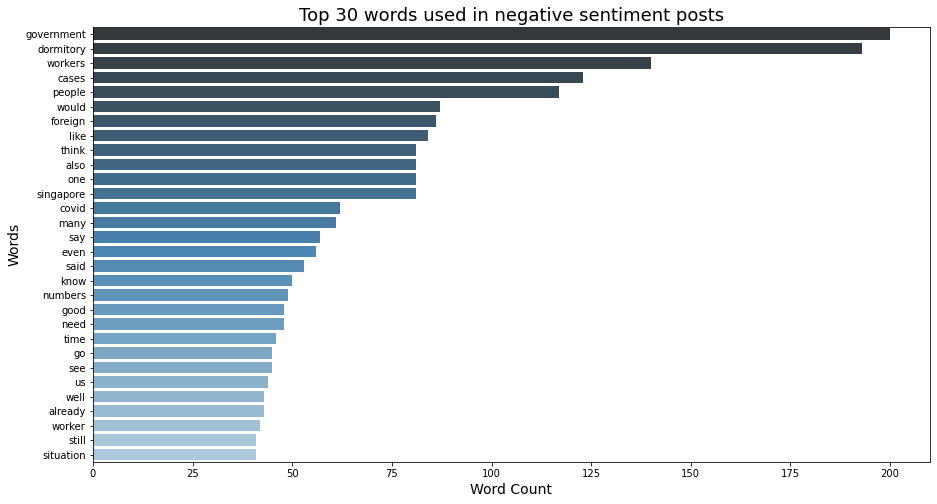

In [9]:
#barplot of most commonly used words 

#cvec and sort by most common words
cvec = CountVectorizer()
cvec_posts = pd.DataFrame(cvec.fit_transform(pos['post_clean_lda']).toarray(), 
                         columns=cvec.get_feature_names())

wordcount_df = pd.DataFrame(cvec_posts.sum().sort_values(ascending=False).head(30),columns=['count'])

#barplot 
plt.figure(figsize = (15,8))
sns.barplot(y = wordcount_df.index, x = 'count', data = wordcount_df, 
            palette = 'Blues_d')
plt.title(f'Top 30 words used in negative sentiment posts', fontsize= 18)
plt.xlabel('Word Count', fontsize = 14)
plt.ylabel('Words',fontsize = 14);

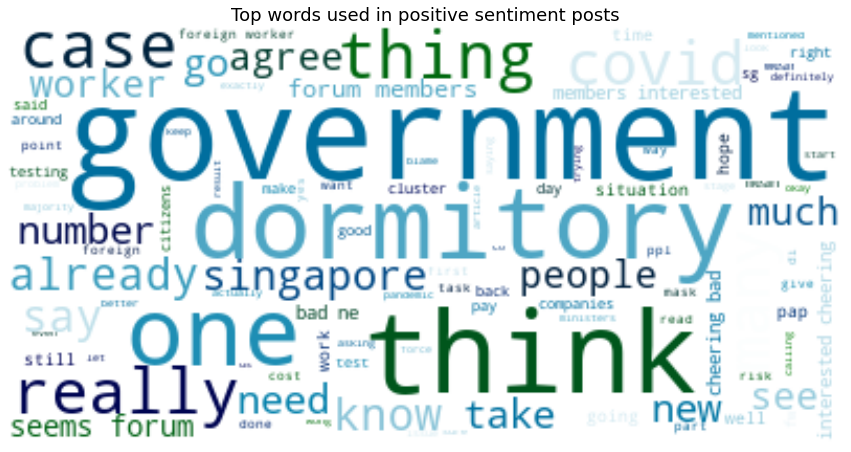

In [10]:
#generate wordcloud 

wc = WordCloud(max_words=100, background_color="white", 
               colormap = 'ocean').generate(pos['post_clean_lda'].to_string())
plt.figure(figsize = (15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title(f'Top words used in positive sentiment posts', fontsize= 18);

---
## Vanilla LDA topic modeling

Having experimented with the stopwords/number of topics/number of words in topic modeling

The best LDA model comprised of the following parameters 
- Removing minimal stopwords, only noisy ones: '19', 'virus', 'gagt', 'ah', 'liao', 'lah', 'trt', 'huawei', 'samsung', 'xiaomi', 'l21a', '32'
- Key words such as foreign, workers, dormitories, government, COVID remained
- 5 topics 
- 15 words per topic 

Topics from negative sentiment posts as predicted by a vanilla LDA model with has been optimised via GridSearchCV: 
- Topic 1: **cases dormitory people singapore workers said foreign like news community spread forum numbers would time**
- Topic 2: **dormitory government workers think foreign people one would problem us worker covid even country also**
- Topic 3: **government workers dormitory people would also say see think much mask sg like go need**
- Topic 4: **dormitory cases workers testing government one like foreign also covid still would test know community**
- Topic 5: **government good think must workers know dormitory see still like people companies since many one**

I note that these topics seem like a random bag of words, but on further investigation and research, there is a pattern to the topics. The topics will be explained in the **Insights** section of this notebook. 
- E.g., Topic 1 highlighted the number of cases of COVID-19 from foreign workers living in dormitories, concerned that there would be community spread over time 

In [28]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [30]:
cvec = CountVectorizer()
cvec_data = cvec.fit_transform(pos['post_clean_lda'])

# Tweak the two parameters below
number_topics = 6
number_words = 15

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1, random_state=42)
lda.fit(cvec_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, cvec, number_words)

Topics found via LDA:

Topic #0:
cases dormitory workers people singapore foreign spread like forum said numbers community would news also

Topic #1:
government dormitory workers think foreign people would us one problem singapore covid worker country also

Topic #2:
government people would dormitory see think also mask say time much need hindsight really like

Topic #3:
dormitory cases testing workers like foreign also one know government covid community sg people well

Topic #4:
government good think workers singapore like dormitory must test know since see many companies kits

Topic #5:
government dormitory workers many one would problem take really foreign singapore like people cases days


In [13]:
#performance of LDA model for positive sentiment posts 

display(lda.score(cvec_data))
display(lda.perplexity(cvec_data))
display(lda.get_params())

-113606.62991090579

2476.151247830832

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 6,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

In [14]:
#Optimise LDA model with GridsearchCV 

params = {'n_components': [5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=params, n_jobs=-1, verbose=1)

model.fit(cvec_data)

display(model.best_params_)
display(model.score)

#topics from LDA model with optimised params
number_topics = 5
number_words = 15

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1, learning_decay=0.9, random_state=42)
lda.fit(cvec_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, cvec, number_words)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


{'learning_decay': 0.7, 'n_components': 5}

<bound method BaseSearchCV.score of GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 6, 7, 8, 9, 10]},
             verbose=1)>

Topics found via LDA:

Topic #0:
cases dormitory people singapore workers said foreign like spread news community forum numbers would time

Topic #1:
dormitory government workers think foreign people one would problem us worker covid even country also

Topic #2:
government workers dormitory people would also say see think much mask sg like go need

Topic #3:
dormitory cases workers testing government one like foreign also covid still would test know community

Topic #4:
government good think must workers know dormitory see still like people companies since many one


---
## LDA topic modeling with MALLET

Topics found with optimised LDA topic modeling with MALLET 
- Topic 1: **cases, community, numbers, dormitory, news, forum, big, spread, cb, world**
- Topic 2: **conditions, pay, migrant, thing, issue, country, cost, distancing, operators, singaporeans**
- Topic 3: **government, sg, high, citizens, companies, care, hard, day,agree, lot**
- Topic 4: **people, masks, time, mask, lockdown, weeks, home, hindsight, long, wearing**
- Topic 5: **work, make, clusters, measures, start, point, days, making, made, life**
- Topic 6: **people, government, things, working, worker, part, wrong, sense, numbers, coming**

In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

data_words = list(sent_to_words(pos['post_clean_lda']))

print(data_words[:1])

[['new', 'cluster', 'beside', 'dormitory', 'two', 'days']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('beside', 1),
  ('cluster', 1),
  ('days', 1),
  ('dormitory', 1),
  ('new', 1),
  ('two', 1)]]

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
        mallet_path = '/Users/dorafoong/Desktop/capstone/mallet-2.0.8/bin/mallet' #update this path 
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_words, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

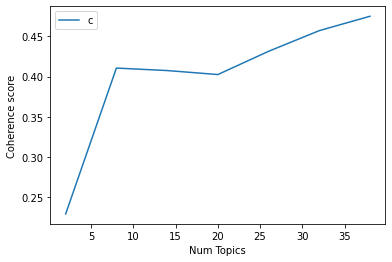

In [25]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# set number of topics = 7 as it is the local maximum, any more than 10 could result in overfit 
# due to the small number of positive sentiment posts (241 posts)

#fit ldamallet model with optimal number of topics 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)

# show topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('cases', 0.065698041692988),
   ('community', 0.024636765634870498),
   ('numbers', 0.020846493998736577),
   ('dormitory', 0.02021478205938092),
   ('news', 0.017687934301958308),
   ('forum', 0.016424510423247),
   ('big', 0.016424510423247),
   ('spread', 0.016424510423247),
   ('cb', 0.015161086544535692),
   ('world', 0.013265950726468731)]),
 (1,
  [('conditions', 0.019071837253655435),
   ('pay', 0.01652892561983471),
   ('migrant', 0.01589319771137953),
   ('thing', 0.015257469802924348),
   ('issue', 0.014621741894469168),
   ('country', 0.013986013986013986),
   ('cost', 0.013350286077558804),
   ('distancing', 0.012078830260648443),
   ('operators', 0.012078830260648443),
   ('singaporeans', 0.01144310235219326)]),
 (2,
  [('government', 0.1039307128580946),
   ('sg', 0.02465023317788141),
   ('high', 0.018654230512991338),
   ('citizens', 0.015989340439706862),
   ('companies', 0.015323117921385743),
   ('care', 0.014656895403064623),
   ('hard', 0.0146568954030646

---
## Best model and insights from topics of positive sentiment posts

Topics found with optimised vanilla LDA topic modeling (with explanation): 
- Topic 1: **cases dormitory people singapore workers said foreign like news community spread forum numbers would time**
    - highlighted concerns over community spread due to COVID-19 cases in foreign worker dorms 
- Topic 2: **dormitory government workers think foreign people one would problem us worker covid even country also**
    - highlighted that government had to address problems of COVID-19 cases in foreign worker dorms 
- Topic 3: **government workers dormitory people would also say see think much mask sg like go need**
    - highlighted mask wearing, government
- Topic 4: **dormitory cases workers testing government one like foreign also covid still would test know community**
    - highlighted testing of foreign workers residing in dorms by the government 
- Topic 5: **government good think must workers know dormitory see still like people companies since many one**
    - highlighted how government was performing well ("government", "good")

Topics found with optimised LDA topic modeling with MALLET (with explanation):
- Topic 1: **cases, community, numbers, dormitory, news, forum, big, spread, cb, world**
    - highlighted high ("big") number of COVID-19 cases in dorms, potential for community spread and the circuit breaker ("cb")
- Topic 2: **conditions, pay, migrant, thing, issue, country, cost, distancing, operators, singaporeans**
    - highlighted poor conditions and pay of migrant workers, cost of distancing workers, responsibility of dorm operators(??) ("operators")
- Topic 3: **government, sg, high, citizens, companies, care, hard, day, agree, lot**
    - pointed out that government cared for citizens and companies
- Topic 4: **people, masks, time, mask, lockdown, weeks, home, hindsight, long, wearing**
    - highlighted COVID-19 situation in Singapore - mask wearing, lockdown for weeks/long time, benefit of "hindsight" 
- Topic 5: **work, make, clusters, measures, start, point, days, making, made, life**
    - highlighted clusters, possibly mentioned measures to stop spread

Based on research on the subject matter, the **topics generated by the LDA model with MALLET** seem to have fared better, as they seem more coherent and interpretable

However, the topics generated from positive sentiment posts do not seem as informative as topics generated from negative sentiment posts (notebook: 5_1_topic_modeling_negative). This could be attributed to the lack of data from positive sentiment posts due to unbalanced classes in the dataset - over 1120 (about 10% of all posts) negative sentiment posts but only 241 positive sentiment posts (about 2% of dataset).